# Arable Land Area (percentage of total land area)
In this notebook we will predict Arable Land Area of a country based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing Arable Land data 

- Combining Arable Land data with Predictor data
- Exploring correlations within the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (Arable Land) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population)
- Fitting simple mixed effects models with each predictor seperately (time, population, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [6]:
#Read file 
df = pd.read_csv('Data/arable_land_percent.csv', skiprows=4)

print(df)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Arable land (% of land area)   
1    Africa Eastern and Southern          AFE  Arable land (% of land area)   
2                    Afghanistan          AFG  Arable land (% of land area)   
3     Africa Western and Central          AFW  Arable land (% of land area)   
4                         Angola          AGO  Arable land (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Arable land (% of land area)   
262                  Yemen, Rep.          YEM  Arable land (% of land area)   
263                 South Africa          ZAF  Arable land (% of land area)   
264                       Zambia          ZMB  Arable land (% of land area)   
265                     Zimbabwe          ZWE  Arable land (% of land area)   

     Indicator Code  1960       1961       1962    

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            224 non-null    float64
 6   1962            224 non-null    float64
 7   1963            224 non-null    float64
 8   1964            224 non-null    float64
 9   1965            224 non-null    float64
 10  1966            224 non-null    float64
 11  1967            224 non-null    float64
 12  1968            224 non-null    float64
 13  1969            224 non-null    float64
 14  1970            224 non-null    float64
 15  1971            224 non-null    float64
 16  1972            224 non-null    float64
 17  1973            224 non-null    flo

In [21]:
summary = df.describe().loc['count']

print(summary)

1960             0.0
1961           224.0
1962           224.0
1963           224.0
1964           224.0
               ...  
2020           255.0
2021           255.0
2022             0.0
2023             0.0
Unnamed: 68      0.0
Name: count, Length: 65, dtype: float64


We need to remove 1960, 2022, 2023 columns

In [22]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

#Removing zero count columns from data
df_full = df.drop(columns=columns_with_zero_count)

print(df_full)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Arable land (% of land area)   
1    Africa Eastern and Southern          AFE  Arable land (% of land area)   
2                    Afghanistan          AFG  Arable land (% of land area)   
3     Africa Western and Central          AFW  Arable land (% of land area)   
4                         Angola          AGO  Arable land (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Arable land (% of land area)   
262                  Yemen, Rep.          YEM  Arable land (% of land area)   
263                 South Africa          ZAF  Arable land (% of land area)   
264                       Zambia          ZMB  Arable land (% of land area)   
265                     Zimbabwe          ZWE  Arable land (% of land area)   

     Indicator Code       1961       1962       196

In [25]:
df_full.describe()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,12.639957,12.649161,12.717302,12.734831,12.754424,12.742233,12.755740,12.784186,12.811566,12.797079,...,13.433067,13.437617,13.442669,13.538033,13.562563,13.587552,13.568039,13.554414,13.557966,13.584161
std,13.520620,13.457387,13.414695,13.366287,13.355101,13.266623,13.280801,13.304425,13.315461,13.248597,...,12.769282,12.819343,12.819881,12.868714,12.900111,12.901381,12.887218,12.894363,12.861983,12.926041
min,0.043141,0.043141,0.043141,0.043141,0.043141,0.043141,0.043141,0.043141,0.043141,0.043141,...,0.045845,0.045845,0.045845,0.045845,0.047278,0.047278,0.047278,0.047278,0.051245,0.051095
25%,3.019515,3.036514,3.058788,3.091610,3.115933,3.145427,3.174801,3.196124,3.198957,3.213871,...,4.147471,4.134323,4.128940,4.128940,4.147471,4.143780,4.147471,4.138576,4.191515,4.185140
50%,8.458062,8.455050,8.435349,8.428775,8.295954,8.652486,8.804004,8.805311,8.687725,8.687725,...,9.943129,10.197093,10.109677,10.290698,10.190814,10.208874,10.236889,10.190814,10.277058,10.290698
75%,16.166117,16.047781,16.311017,16.474374,16.697080,16.845860,16.779805,17.229371,16.924434,17.014387,...,18.522887,18.555747,17.196935,18.676173,18.584020,18.805574,18.243462,18.392225,18.392225,18.392225
max,70.175000,69.325000,68.600000,68.150000,67.427211,67.588538,67.934240,67.826688,67.680725,67.888146,...,60.450000,60.190000,60.800000,59.401091,59.646693,59.593839,59.710000,61.204579,61.458093,62.303142


In [38]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']


df_iso = df_full[df_full['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  Arable land (% of land area)  AG.LND.ARBL.ZS   
2     Afghanistan          AFG  Arable land (% of land area)  AG.LND.ARBL.ZS   
4          Angola          AGO  Arable land (% of land area)  AG.LND.ARBL.ZS   
5         Albania          ALB  Arable land (% of land area)  AG.LND.ARBL.ZS   
6         Andorra          AND  Arable land (% of land area)  AG.LND.ARBL.ZS   
..            ...          ...                           ...             ...   
260         Samoa          WSM  Arable land (% of land area)  AG.LND.ARBL.ZS   
262   Yemen, Rep.          YEM  Arable land (% of land area)  AG.LND.ARBL.ZS   
263  South Africa          ZAF  Arable land (% of land area)  AG.LND.ARBL.ZS   
264        Zambia          ZMB  Arable land (% of land area)  AG.LND.ARBL.ZS   
265      Zimbabwe          ZWE  Arable land (% of land area)  AG.LND.ARBL.ZS   

          1961       1962       1963   

Make df long

In [39]:
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='arable_land')

print(melted_df)

      Country Code  Country Name                Indicator Name  \
0              ABW         Aruba  Arable land (% of land area)   
1              AFG   Afghanistan  Arable land (% of land area)   
2              AGO        Angola  Arable land (% of land area)   
3              ALB       Albania  Arable land (% of land area)   
4              AND       Andorra  Arable land (% of land area)   
...            ...           ...                           ...   
13110          WSM         Samoa  Arable land (% of land area)   
13111          YEM   Yemen, Rep.  Arable land (% of land area)   
13112          ZAF  South Africa  Arable land (% of land area)   
13113          ZMB        Zambia  Arable land (% of land area)   
13114          ZWE      Zimbabwe  Arable land (% of land area)   

       Indicator Code  Year  arable_land  
0      AG.LND.ARBL.ZS  1961    11.111111  
1      AG.LND.ARBL.ZS  1961    11.728991  
2      AG.LND.ARBL.ZS  1961     2.141654  
3      AG.LND.ARBL.ZS  1961    15.7

In [30]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16226 entries, 0 to 16225
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    16226 non-null  object 
 1   Country Name    16226 non-null  object 
 2   Indicator Name  16226 non-null  object 
 3   Indicator Code  16226 non-null  object 
 4   Year            16226 non-null  float64
 5   arable_land     14531 non-null  float64
dtypes: float64(2), object(4)
memory usage: 760.7+ KB


In [40]:
melted_df['Year'] = melted_df['Year'].astype(float)

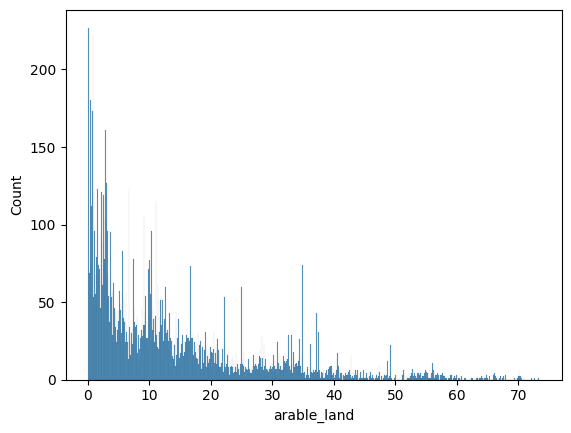

In [41]:
sns.histplot(data=melted_df, x='arable_land', binwidth=0.1)
plt.show()

In [53]:
#Making a list for all countries that have exactly 0.0 percent forest. 

zero_countries = melted_df.groupby('Country Code')['arable_land'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

print(zero_countries)

['CUW', 'GIB', 'GRL', 'MAC', 'MAF', 'MCO', 'NRU', 'SXM', 'TUV']


In [51]:
#Remove 0.0 columns and non countries 
#Removing zero count columns from data
#df_try = df_iso.drop(['Country Code'] == zero_countries)

arable = melted_df[~melted_df['Country Code'].isin(zero_countries)]

print(arable.groupby('Country Code')['arable_land'].sum())

Country Code
ABW     677.777778
AFG     731.122457
AGO     165.789685
ALB    1262.629416
AND     120.515106
          ...     
WSM     325.609223
YEM     155.537246
ZAF     632.550759
ZMB     241.782913
ZWE     487.889363
Name: arable_land, Length: 206, dtype: float64


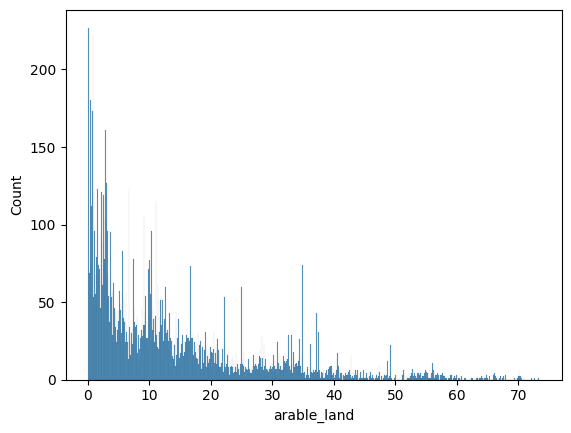

In [58]:
sns.histplot(data=arable, x='arable_land', binwidth=0.1)
plt.show()


We still have some 0. somethings with makes it hard with the log transformation. 

In [87]:
# Group the DataFrame by iso code and year
grouped_df = arable.groupby(['Country Code', 'Year'])

# Filter the groups to keep only the rows where the values are between 0 and 0.01
filtered_df = grouped_df.filter(lambda x: (x['arable_land'] >= 0) & (x['arable_land'] <= 0.01))

# Display the filtered DataFrame
print(filtered_df)

Empty DataFrame
Columns: [Country Code, Country Name, Indicator Name, Indicator Code, Year, arable_land, log_arable]
Index: []


In [92]:
arable['arable_land'].isna().sum()

1024

We do have 1024 Na's

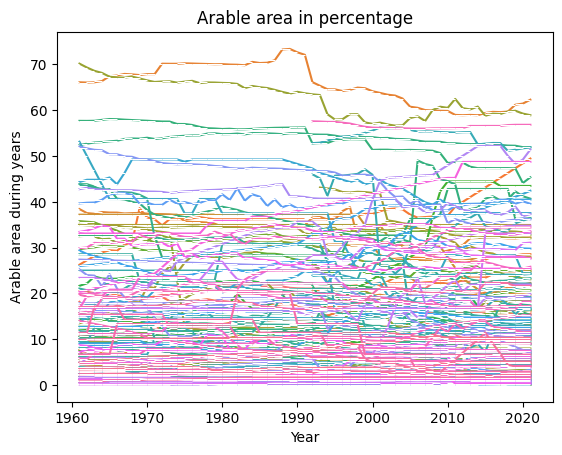

In [55]:
sns.lineplot(data=arable, x='Year', y='arable_land', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Arable area in percentage')
plt.xlabel('Year')
plt.ylabel('Arable area during years')


# Show the plot
plt.show()

In [83]:

arable['log_arable'] = np.log(arable['arable_land'])

# Check the result
print(arable.head())

  Country Code Country Name                Indicator Name  Indicator Code  \
0          ABW        Aruba  Arable land (% of land area)  AG.LND.ARBL.ZS   
1          AFG  Afghanistan  Arable land (% of land area)  AG.LND.ARBL.ZS   
2          AGO       Angola  Arable land (% of land area)  AG.LND.ARBL.ZS   
3          ALB      Albania  Arable land (% of land area)  AG.LND.ARBL.ZS   
4          AND      Andorra  Arable land (% of land area)  AG.LND.ARBL.ZS   

     Year  arable_land  log_arable  
0  1961.0    11.111111    2.407946  
1  1961.0    11.728991    2.462064  
2  1961.0     2.141654    0.761578  
3  1961.0    15.766423    2.757883  
4  1961.0     2.127660    0.755023  


C:\Users\mlj\AppData\Local\Temp\ipykernel_21984\4148815014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arable['log_arable'] = np.log(arable['arable_land'])


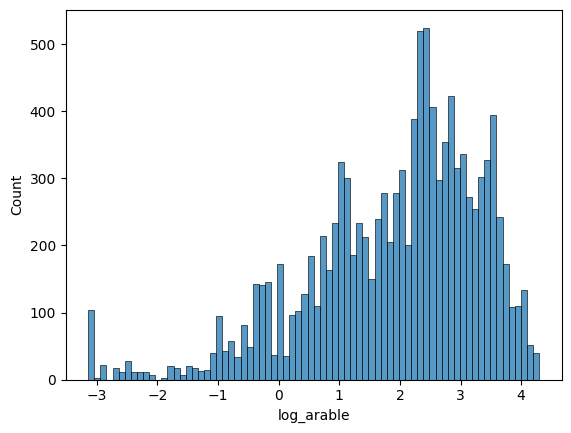

In [84]:
sns.histplot(data=arable, x='log_arable', binwidth=0.1)
plt.show()

1024